In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import linear_model
import copy
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns
import pandas as pd
import numpy as np
import math
import os

import file_structure

def get_accuracy(all_gt, all_label):
    return len(np.argwhere(all_gt.reshape([-1,1])==all_label.reshape([-1,1])))/float(len(all_gt))

def Youden_Cutoff_auc_sen_spc(y_true, y_prob):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    y_true : Matrix with dependent or target data, where rows are observations

    y_pred : Matrix with predicted data, where rows are observations

    Returns
    -------     
    auc, youden sensitivity and youden specificity
    """

    fpr, tpr, threshold = roc_curve(y_true, y_prob)

    spc = 1-fpr;
    j_scores = tpr-fpr
    best_youden, youden_thresh, youden_sen, youden_spc = sorted(zip(j_scores, threshold, tpr, spc))[-1]

    predicted_label = copy.deepcopy(y_prob)
    predicted_label[predicted_label>youden_thresh] = 1
    predicted_label[predicted_label<youden_thresh] = 0
    youden_accuracy = get_accuracy(y_true, predicted_label)

    auc = roc_auc_score(y_true, y_prob)

    return auc, youden_sen, youden_spc, youden_accuracy, fpr, tpr, threshold, youden_thresh

def auc_95confidence(y_true,y_prob):

    # https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals

    n_bootstraps = 1000
    bootstrapped_scores = []
    np.random.seed(seed)

    for i in range(n_bootstraps):
        indices = np.random.choice(range(0, len(y_prob)), len(y_prob), replace=True)
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_prob[indices])
        bootstrapped_scores.append(score)
    
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    #print(sorted_scores)
    #print(int(0.05 * len(sorted_scores)))
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return confidence_lower, confidence_upper

def compute_metrics(y_true, y_prob):
    """
    y_true: true label
    y_prob: probability score for class 1
    """
    y_pred = np.round(y_prob)

    #acc = get_accuracy(y_true, y_pred)
    auc, sen, spe, youden_acc, fpr, tpr, threshold, youden_thresh = Youden_Cutoff_auc_sen_spc(y_true, y_prob)
    lower, upper = auc_95confidence(y_true, y_prob)

    return auc, sen, spe, youden_acc, lower, upper, fpr, tpr, threshold, youden_thresh

def organize_result(result_dict, case, y_true, y_prob,case_suffix = '',suffix=''):
    
    if not case in result_dict:
        result_dict[case] = {}
    
    auc, sen, spe, youden_acc, lower, upper, fpr, tpr, threshold, youden_thresh = compute_metrics(y_true, y_prob)
    cv_score = np.load(os.path.join(model_dir,'%s%s_best_cv_score%s.npy'%(case_str,case_suffix,suffix)))
    #pval = auc_p_val(y_true,y_prob)
    val_map = {'Youden Accuracy': youden_acc, 'Sensitivity': sen, 'Specificity': spe,
              'AUC': auc, 'AUC Upper': upper, 'AUC Lower': lower, 'fpr': fpr, 'tpr': tpr,
              'threshold': threshold, 'Youden thresh': youden_thresh, 'CV AUC': cv_score}
    
    for key, val in val_map.items():
        #if key in result_dict[case]:
        #    result_dict[case][key] = np.append(result_dict[case][key],val)
        #else: 
        #    result_dict[case][key] = [val]
        result_dict[case][key] = val
    
    return result_dict

def draw_ROC_curve(result_dict,suffix = ''):

    fig_handle=plt.figure(figsize=(9,8),dpi = 80)
    colors = (['plum','salmon','deeppink', 'darkorange','navy','aqua', 'cornflowerblue','lime','orchid',
               'lightcoral','darkcyan','firebrick','forestgreen'])
    lw = 2

    # organize in order of smallest to largest AUC
    res_list = list()
    
    res_keys = list(result_dict.keys())
    for i in range(len(res_keys)):
        case = res_keys[i]
        res_list.append((case,result_dict[case]['AUC'],result_dict[case]['fpr'],result_dict[case]['tpr'],colors[i]))

    ordered_list = sorted(res_list, key = lambda case: case[1])

    #plot
    for ind in range(len(ordered_list)):
        # print(ordered_list[ind][0])

        plt.plot(ordered_list[ind][2], ordered_list[ind][3], color =ordered_list[ind][4], lw= lw,
                label = '{0} ROC curve (area = {1:0.3f})'
                ''.format(ordered_list[ind][0], ordered_list[ind][1]))
        plt.plot(ordered_list[ind][2], ordered_list[ind][3], color = ordered_list[ind][4], lw= lw)

    plt.plot([0,1],[0,1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.tick_params(
        axis='both',
        labelbottom = 'off',
        labelleft = 'off')
    plt.tick_params(axis='both', which= 'major', labelsize = 18)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for test set')
    plt.legend(loc="lower right")

    #plt.show()
    plt.savefig(os.path.join(out_dir,'texture_roc'+suffix+'.png'))

    return None

def label_conversion(numpy_labels):
    labels = numpy_labels.tolist()
    labels_str = list()

    for i in range(len(labels)):

        if numpy_labels[i] == 0:
            labels_str.append('non-codel')
        else:
            labels_str.append('codel')

    return labels_str

def auc_p_val(y_true,y_prob):
    # one sided test against random
    n_permutes = 100000
    random_scores = np.empty(n_permutes)
    np.random.seed(seed)

    for i in range(n_permutes):
        perm_labels = np.random.permutation(y_true)
        score = roc_auc_score(perm_labels, y_prob)
        random_scores[i] = score

    comp_score = roc_auc_score(y_true, y_prob)
    score_ct = np.count_nonzero(random_scores>comp_score)
    pval = float(score_ct)/n_permutes
    plt.hist(random_scores, bins=100, label='random AUCs')
    plt.axvline(x = comp_score, label='computed AUC',color ='r')
    plt.legend(loc = 'upper right')
    plt.title('AUC distribution')
    plt.xlabel('AUC')
    plt.show()
    return pval

texture fold number: 0
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\rf_features_clin_ppt_0_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\logreg_features_clin_ppt_0_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


texture fold number: 1
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\rf_features_clin_ppt_1_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\logreg_features_clin_ppt_1_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


texture fold number: 2
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\rf_features_clin_ppt_2_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\logreg_features_clin_ppt_2_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


texture fold number: 3
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\rf_features_clin_ppt_3_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\logreg_features_clin_ppt_3_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


texture fold number: 4
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\rf_features_clin_ppt_4_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\logreg_features_clin_ppt_4_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


texture fold number: 5
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\rf_features_clin_ppt_5_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\logreg_features_clin_ppt_5_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


texture fold number: 6
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\rf_features_clin_ppt_6_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\logreg_features_clin_ppt_6_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


texture fold number: 7
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\rf_features_clin_ppt_7_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\logreg_features_clin_ppt_7_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


texture fold number: 8
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\rf_features_clin_ppt_8_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\logreg_features_clin_ppt_8_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


texture fold number: 9
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\rf_features_clin_ppt_9_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\texture_models\logreg_features_clin_ppt_9_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


TDA fold number: 0
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\rf_features_clin_ppt_0_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\logreg_features_clin_ppt_0_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


TDA fold number: 1
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\rf_features_clin_ppt_1_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\logreg_features_clin_ppt_1_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


TDA fold number: 2
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\rf_features_clin_ppt_2_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\logreg_features_clin_ppt_2_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


TDA fold number: 3
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\rf_features_clin_ppt_3_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\logreg_features_clin_ppt_3_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


TDA fold number: 4
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\rf_features_clin_ppt_4_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\logreg_features_clin_ppt_4_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


TDA fold number: 5
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\rf_features_clin_ppt_5_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\logreg_features_clin_ppt_5_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


TDA fold number: 6
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\rf_features_clin_ppt_6_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\logreg_features_clin_ppt_6_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


TDA fold number: 7
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\rf_features_clin_ppt_7_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\logreg_features_clin_ppt_7_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


TDA fold number: 8
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\rf_features_clin_ppt_8_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\logreg_features_clin_ppt_8_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


TDA fold number: 9
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\rf_features_clin_ppt_9_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\TDA_models\logreg_features_clin_ppt_9_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


CNN fold number: 0
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\rf_features_clin_ppt_0_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\logreg_features_clin_ppt_0_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, sta

CNN fold number: 1
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\rf_features_clin_ppt_1_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\logreg_features_clin_ppt_1_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


CNN fold number: 2
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\rf_features_clin_ppt_2_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\logreg_features_clin_ppt_2_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


CNN fold number: 3
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\rf_features_clin_ppt_3_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\logreg_features_clin_ppt_3_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


CNN fold number: 4
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\rf_features_clin_ppt_4_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\logreg_features_clin_ppt_4_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


CNN fold number: 5
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\rf_features_clin_ppt_5_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\logreg_features_clin_ppt_5_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


CNN fold number: 6
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\rf_features_clin_ppt_6_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\logreg_features_clin_ppt_6_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


CNN fold number: 7
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\rf_features_clin_ppt_7_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\logreg_features_clin_ppt_7_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


CNN fold number: 8
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\rf_features_clin_ppt_8_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\logreg_features_clin_ppt_8_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


CNN fold number: 9
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\rf_features_clin_ppt_9_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\CNN_models\logreg_features_clin_ppt_9_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


cmb fold number: 0
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\rf_features_clin_ppt_0_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\logreg_features_clin_ppt_0_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


cmb fold number: 1
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\rf_features_clin_ppt_1_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\logreg_features_clin_ppt_1_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


cmb fold number: 2
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\rf_features_clin_ppt_2_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\logreg_features_clin_ppt_2_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


cmb fold number: 3
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\rf_features_clin_ppt_3_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\logreg_features_clin_ppt_3_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


cmb fold number: 4
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\rf_features_clin_ppt_4_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\logreg_features_clin_ppt_4_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


cmb fold number: 5
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\rf_features_clin_ppt_5_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\logreg_features_clin_ppt_5_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


cmb fold number: 6
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\rf_features_clin_ppt_6_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\logreg_features_clin_ppt_6_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


cmb fold number: 7
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\rf_features_clin_ppt_7_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\logreg_features_clin_ppt_7_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


cmb fold number: 8
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\rf_features_clin_ppt_8_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\logreg_features_clin_ppt_8_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


cmb fold number: 9
clin_ppt
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\rf_features_clin_ppt_9_icc2.npy
Couldnt find: C:\Users\ncwang\Documents\Rao_lab\1p19q Project\data\data_split_n4\outputs\cmb_models\logreg_features_clin_ppt_9_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


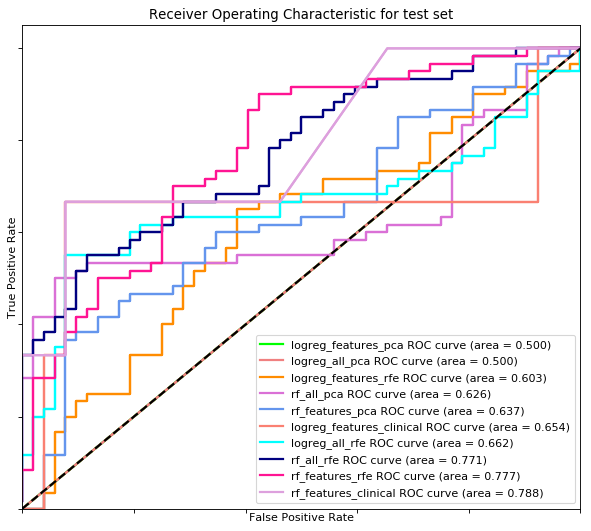

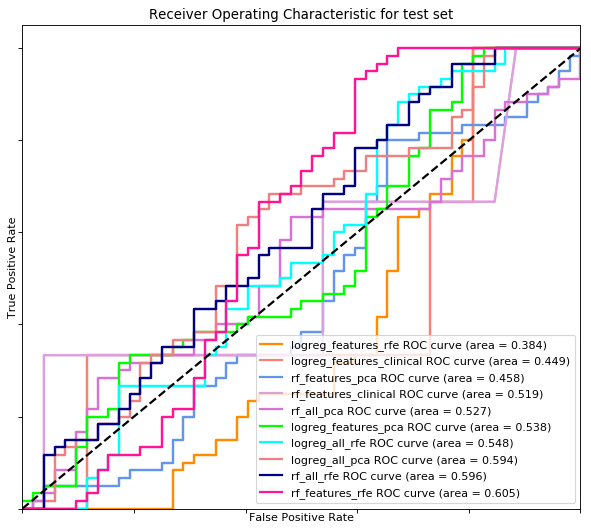

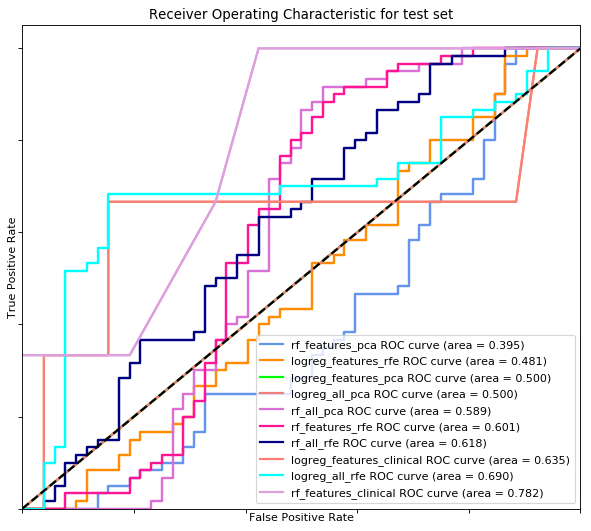

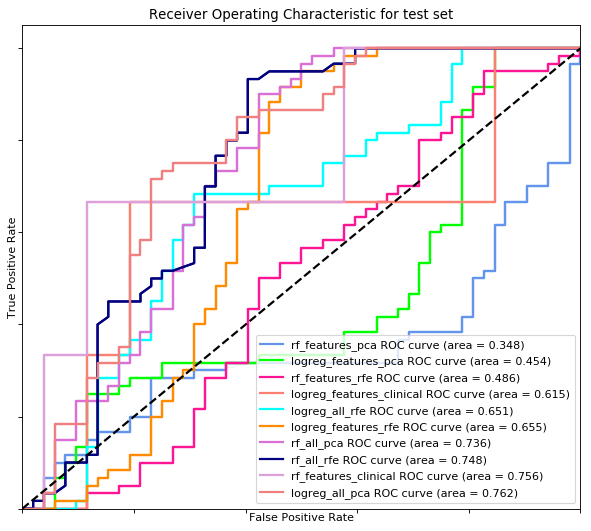

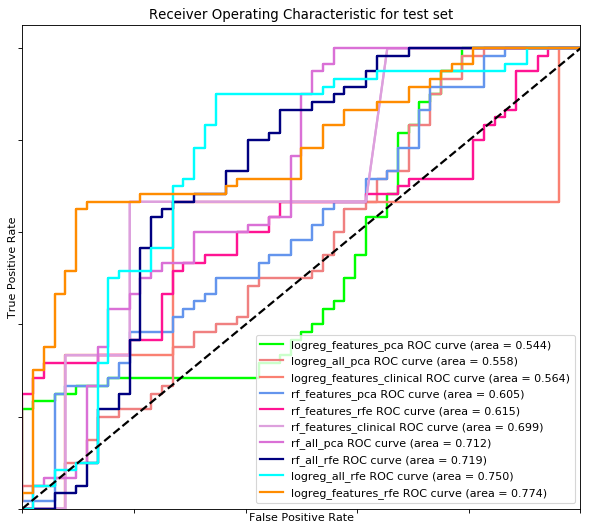

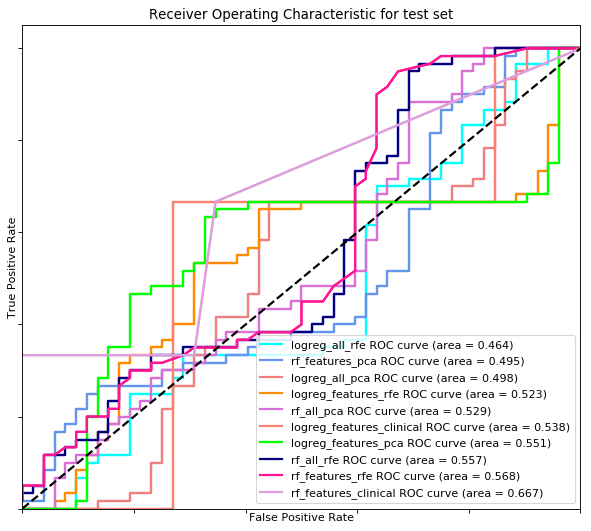

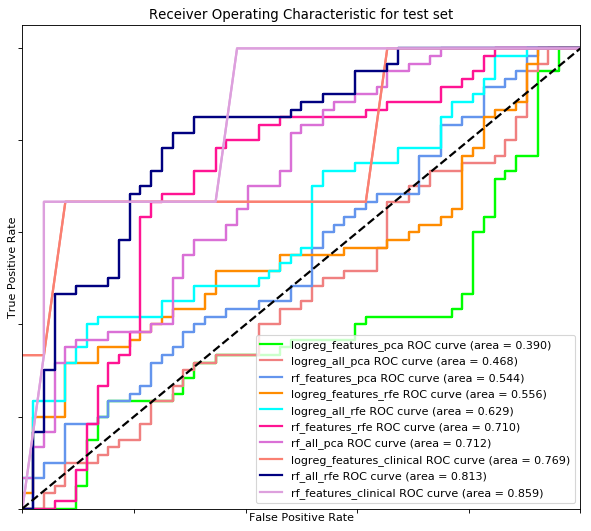

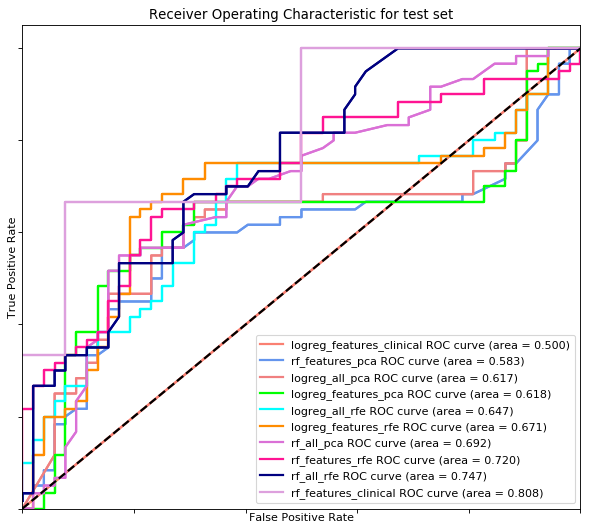

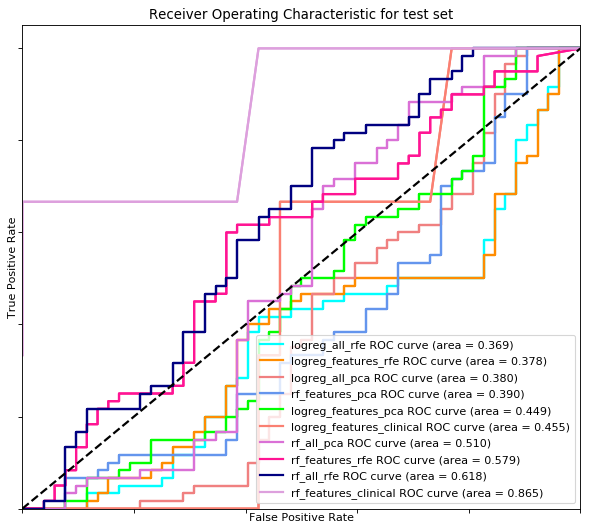

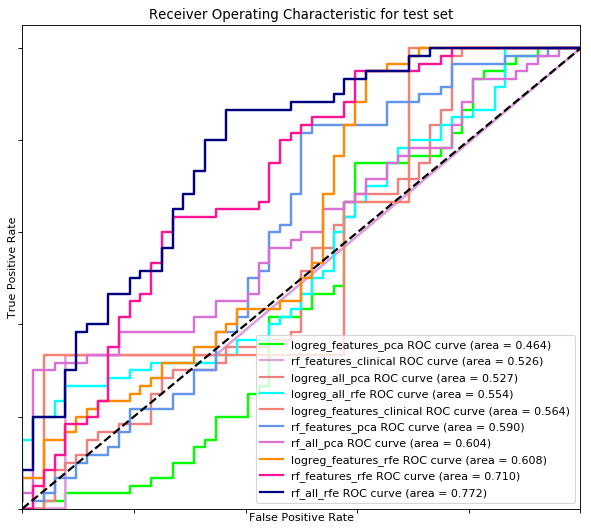

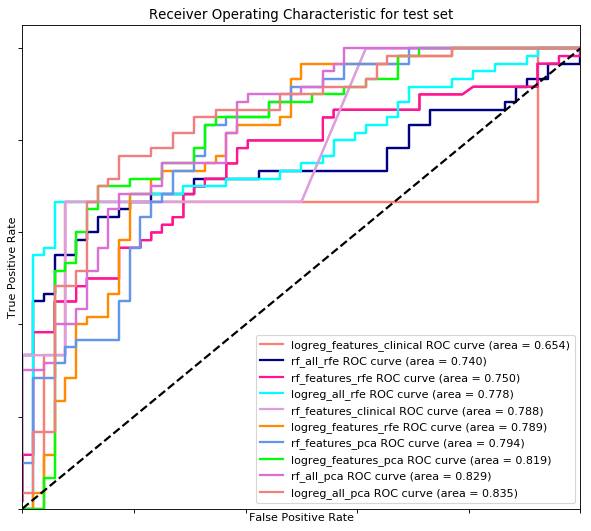

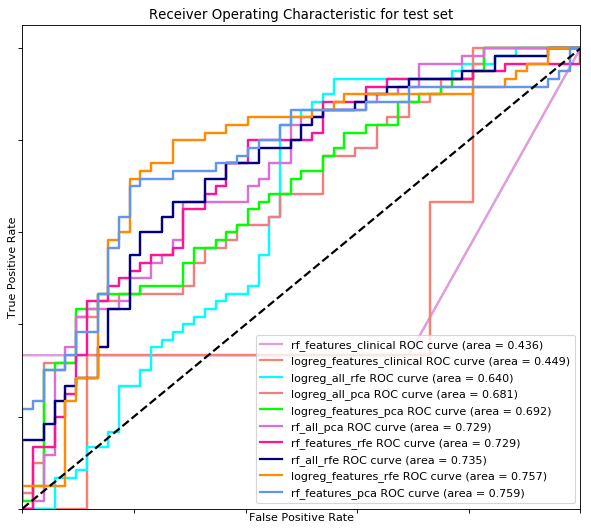

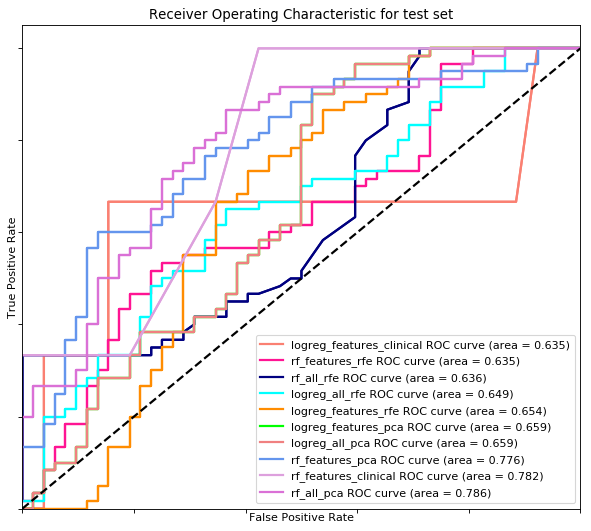

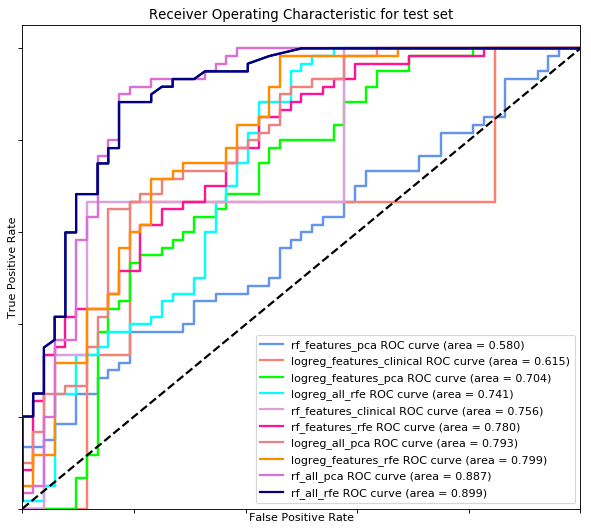

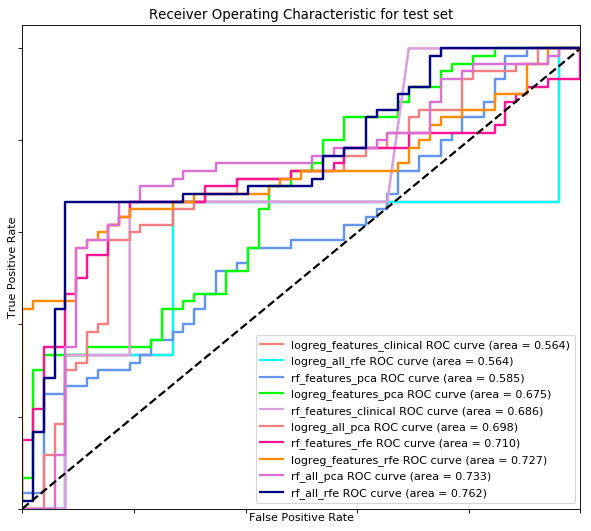

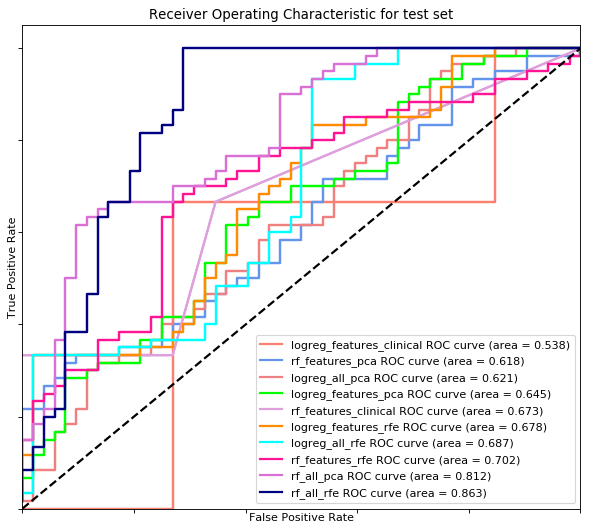

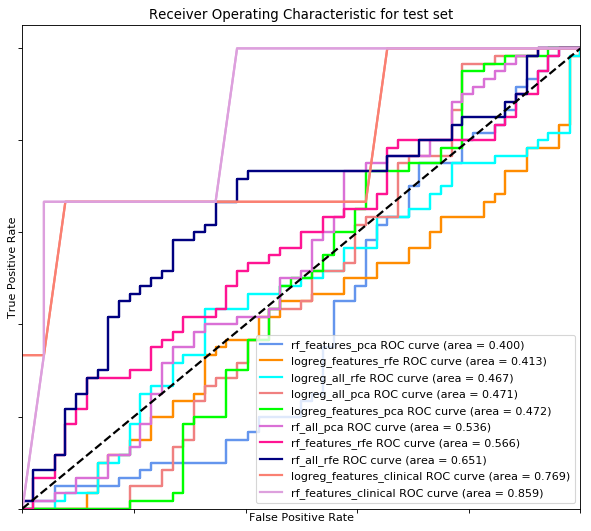

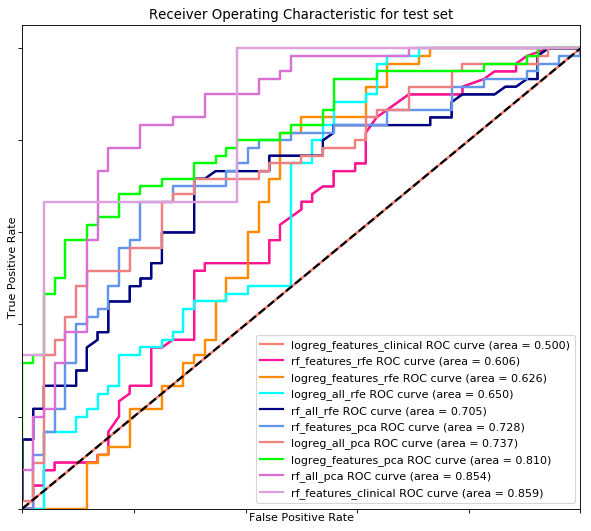

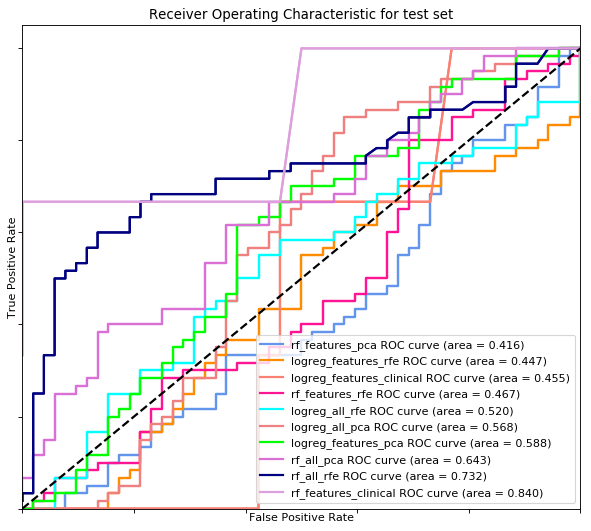

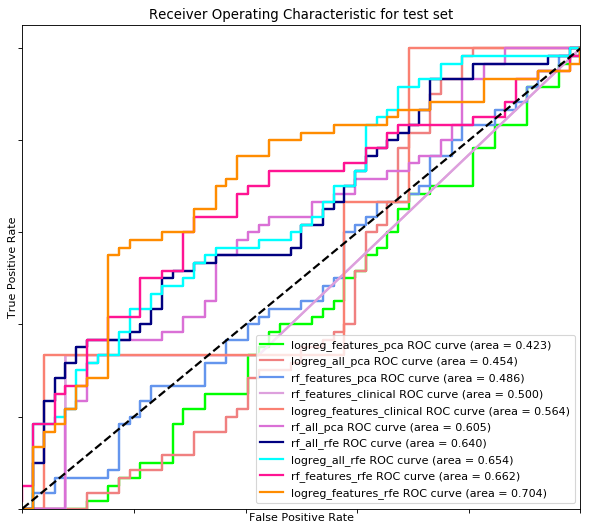

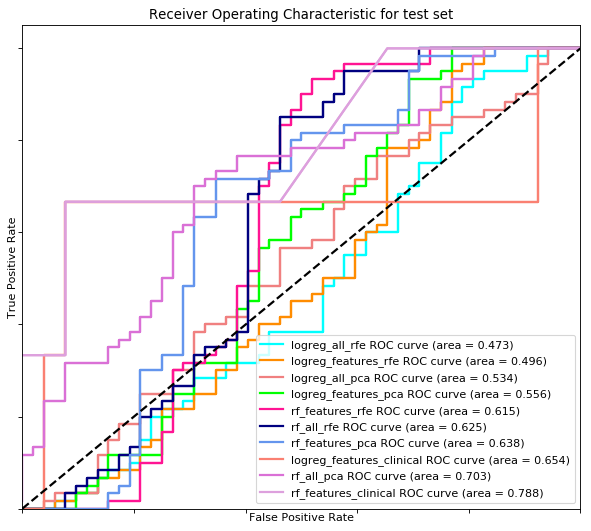

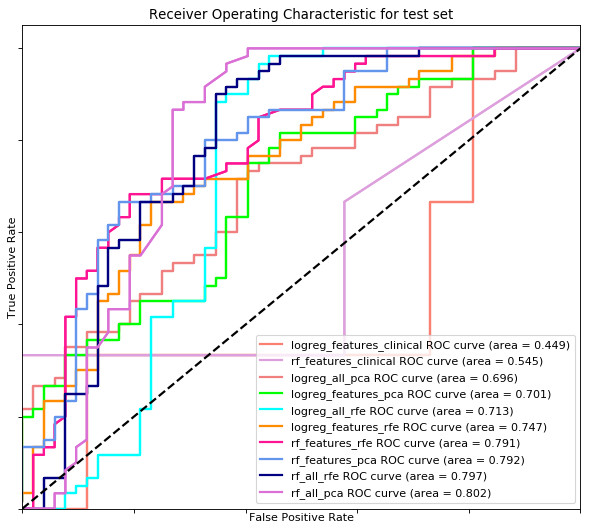

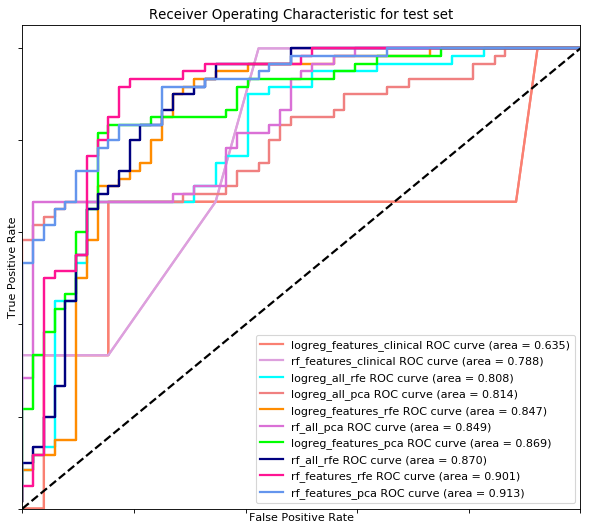

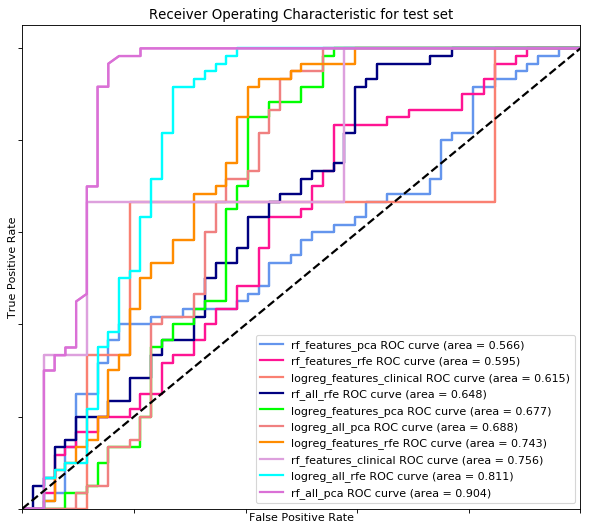

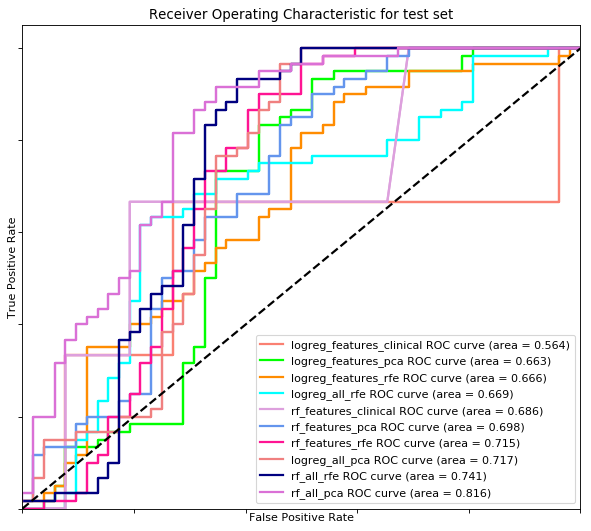

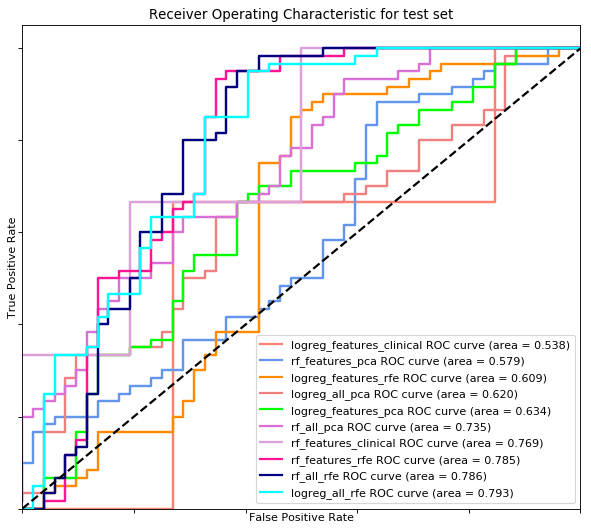

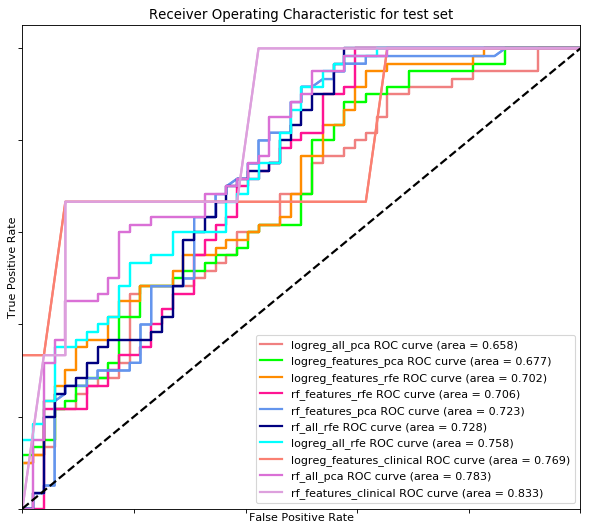

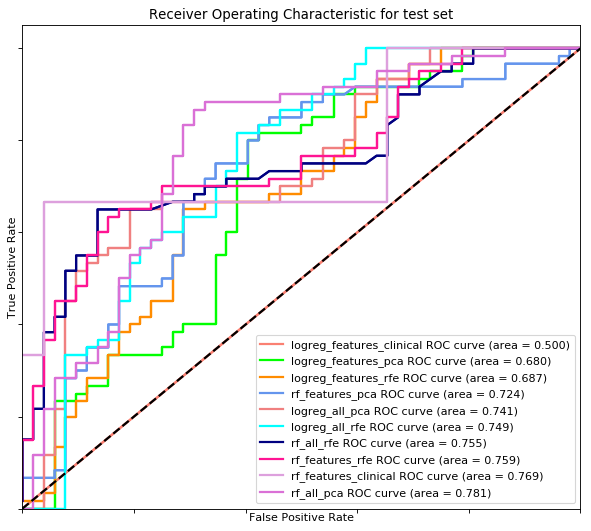

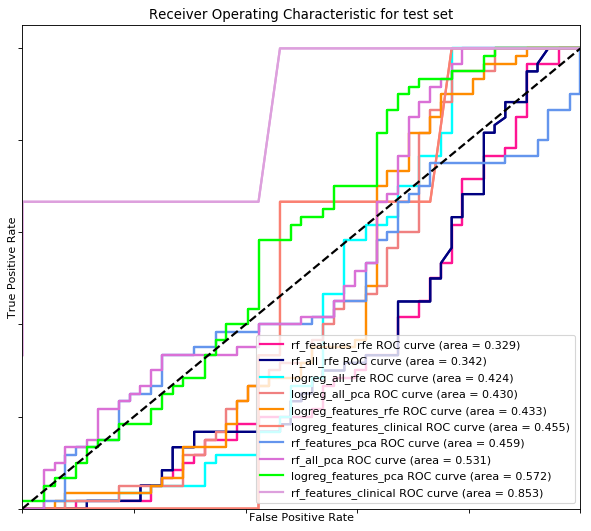

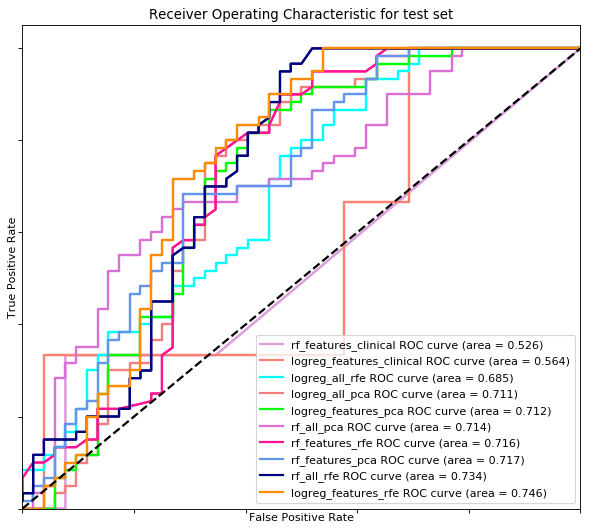

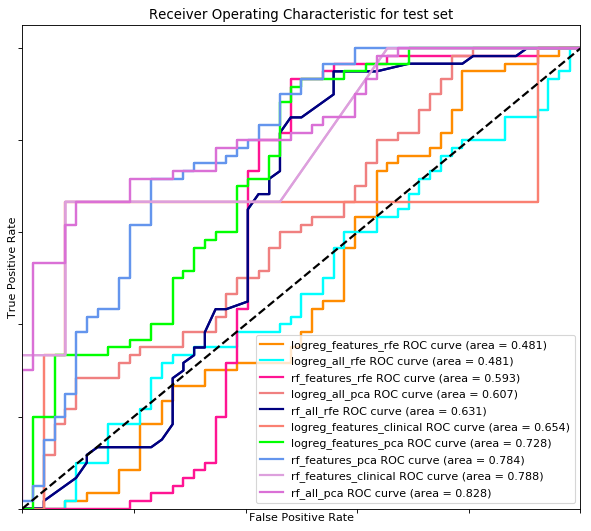

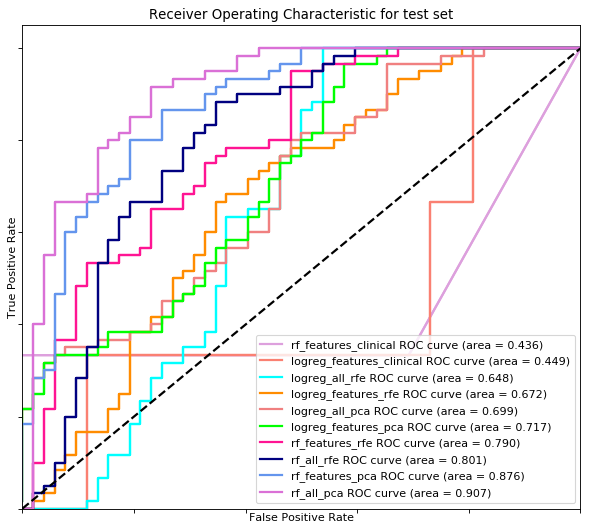

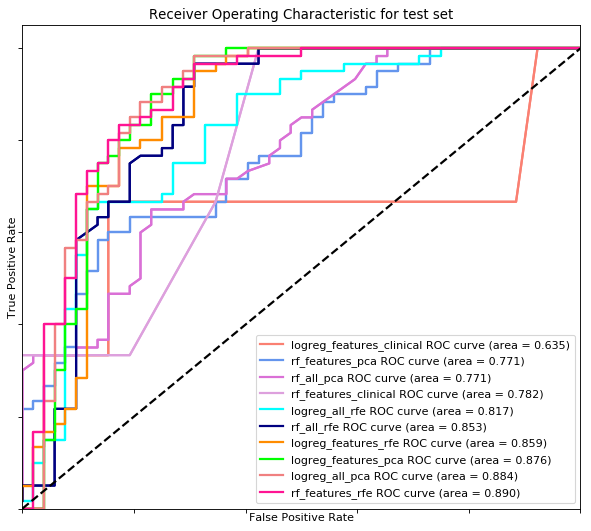

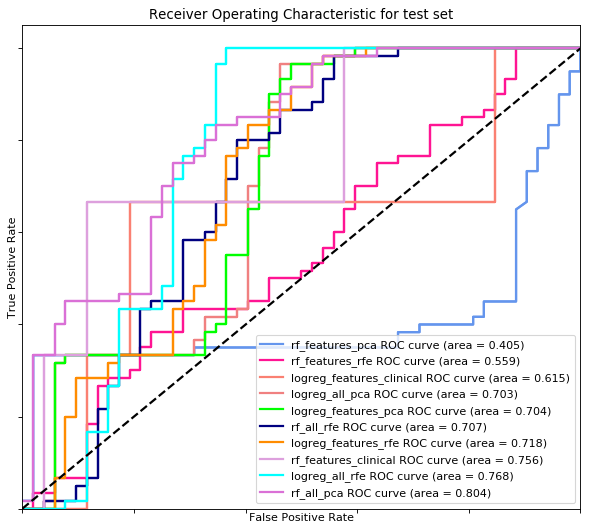

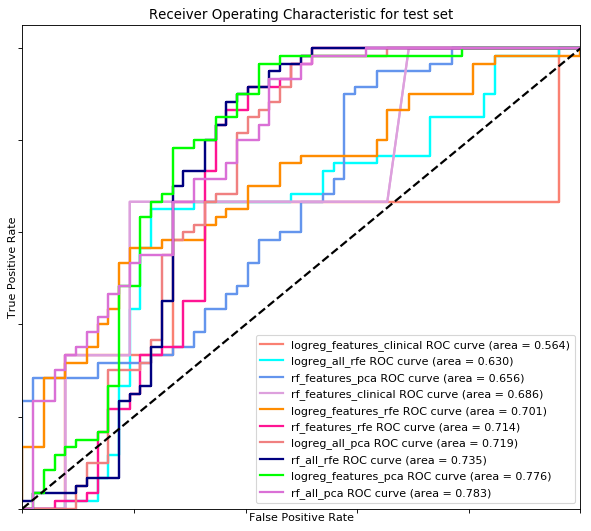

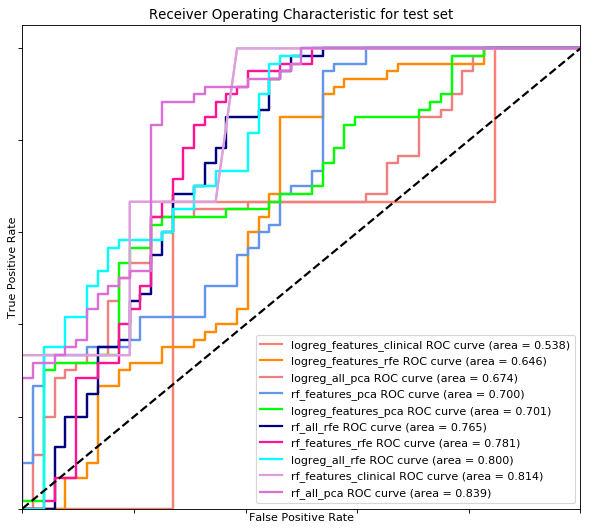

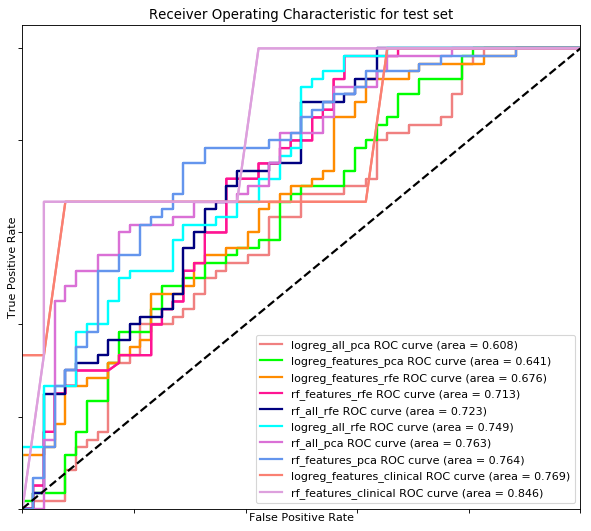

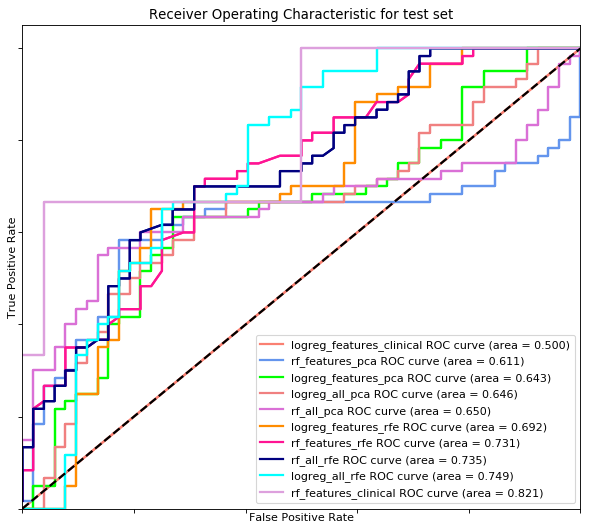

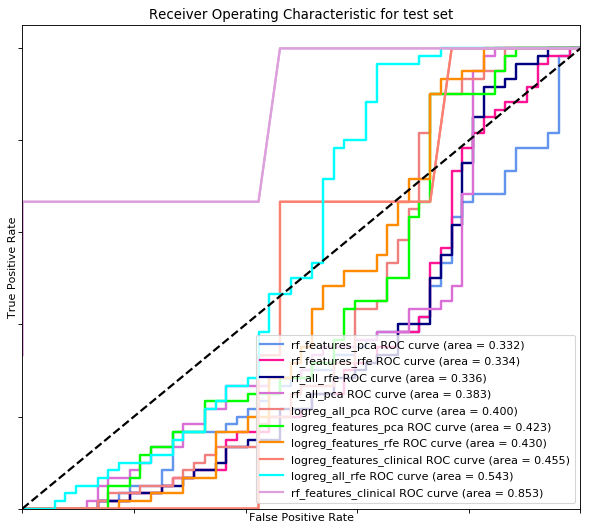

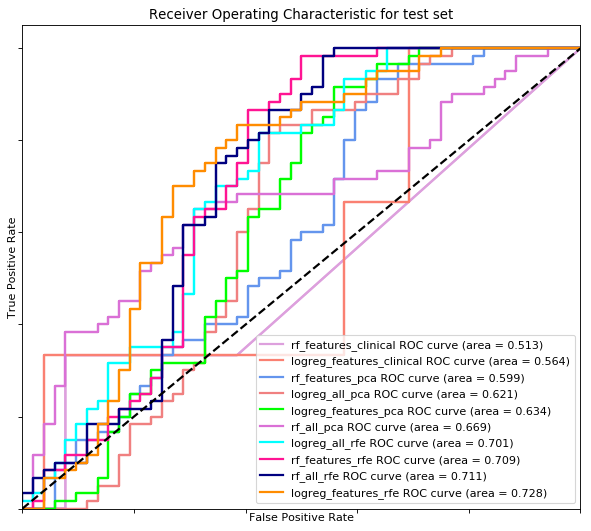

In [5]:
# fix a seed
seed = 0


# load data
import load_data
import glob

# study: 'texture', 'ph', 'CNN'
#study = 'texture' # <== CHANGE HERE
# modals
modal_list = ['FLAIR','T1', 'T1post','T2']

# study_list = ['TDA','texture','CNN','cmb']
# # study_list = ['texture']
# ICC_filt = 0

study_list = [,'cmb']
ICC_filt = 3
for ICC_filt in [1]:
    if ICC_filt == 1:
        suffix = '_icc2'
    elif ICC_filt >= 3:
        suffix = '_icc%i' % ICC_filt
    else: 
        suffix = ''  

    for study in study_list:

        (origdir,basedir,imagedir,normdir,splitdir,out_dir,model_dir) = file_structure.file_dirs(study)
        corr_rfe_selected_list = np.load(os.path.join(out_dir,'rfe_%s_features_selected%s.npy' % (study.lower()[0:3],suffix))).item()
        random_state_list = [2,4,6,8,10,12,14,16,18,20] 


        res_arr = []
        for fold in range(10):
            result = {}
            print('%s fold number: %d' % (study, fold))
            #(train_samples, train_pca , train_1p19q, train_age, train_KPS, train_gender, train_id, train_fnames)= load_data.load_data('train',fold)
            #(val_samples, val_pca , val_1p19q, val_age, val_KPS, val_gender, val_id, val_fnames)= load_data.load_data('val',fold)
            (test_samples, test_pca , test_1p19q, test_age,
             test_KPS, test_gender, test_id, feature_names)= load_data.load_data('test',fold, study,ICC_filt)

            fold_dir = os.path.join(splitdir,'fold_' + str(fold))

            # convert 1,0 into string: 'codel' and 'non-codel'
            test_1p19q_str = label_conversion(test_1p19q)

            # create the pandas dataframes
            data_test_imaging = pd.DataFrame(data=test_samples, columns=feature_names, index=test_1p19q_str)

            clinical_names = ['age', 'KPS', 'gender']
            test_clinical_df = pd.DataFrame(data = np.vstack((test_age, test_KPS, test_gender)).transpose(),
                                            columns = clinical_names, index=test_1p19q_str)
            test_clin_by_pt_df = test_clinical_df.assign(pid = pd.Series(test_id).values)
            test_clin_by_pt_df = test_clin_by_pt_df.groupby('pid').mean()
            #data_test_age = pd.DataFrame(data = np.hstack((test_age)), columns = ['age'], index=test_1p19q_str)


    #         for test_features, rfe_pca_flag in [(test_clin_by_pt_df,'clin_ppt')]:
            for test_features, rfe_pca_flag in [(test_clin_by_pt_df,'clin_ppt'),
                                                (test_clinical_df,'clinical'),
                                                (test_samples,'rfe'),
                                                (test_pca,'pca')]:
    #         for test_features, rfe_pca_flag in [(test_clinical_df,'clinical'),
    #                                             (test_samples,'rfe'),
    #                                             (test_pca,'pca')]:

                if rfe_pca_flag == 'rfe': # original features (i.e. non PCA features). This part needs to be filtered with corr_rfe selection
                    # create the pandas dataframes
                    test_features_df = pd.DataFrame(data=test_features, columns=feature_names, index=test_1p19q_str)

                    # Remove Flatness and LeastAxis since they are all 0s for every sample
                    drop_features = ['shape_Flatness_', 'shape_LeastAxis_']
                    drop_features = [elemt + modal for modal in modal_list for elemt in drop_features]

                    test_features_df = test_features_df.drop(drop_features, axis=1 , errors = 'ignore')

                    # obtain feature names to select from corr + RFE
                    corr_rfe_selected = corr_rfe_selected_list[fold]

                    # only the corr rfe selected features
                    test_features_df = test_features_df[corr_rfe_selected]

                elif rfe_pca_flag == 'pca': #PCA features
                    # create the pandas dataframes            
                    test_features_df = pd.DataFrame(data=test_features, index=test_1p19q_str)

                elif rfe_pca_flag == 'clinical': #PCA features
                    # create the pandas dataframes            
                    test_features_df = pd.DataFrame(data=test_features, index=test_1p19q_str)
                elif rfe_pca_flag == 'clin_ppt':  #clinical per patient variables
                    # create the pandas dataframes
                    test_1p19q_df = pd.DataFrame(data=np.vstack((test_1p19q, test_id)).T, 
                                                  columns=('1p19q','pid'), index=test_1p19q_str)
                    ct_1p19q = test_1p19q_df.groupby('pid')['1p19q'].mean().values

                    test_features_df = pd.DataFrame(data=test_features.values, columns=clinical_names, 
                                                    index=label_conversion(ct_1p19q))


                if rfe_pca_flag == 'clin_ppt': #clinical per patient variables
                    print('clin_ppt')
                else:
                    # features + clinical 
                    test_all_df = pd.concat([test_features_df, test_clinical_df], axis=1)


                for sample_case in ['features', 'all']: #features without clinical vs features + clinical
                    if ((rfe_pca_flag == 'clinical' or rfe_pca_flag == 'clin_ppt')  and sample_case != 'features'):
                        continue # only run clinical once through


                    for classifier in ['rf','logreg']:

                        model_name = classifier + '_' + sample_case + '_' + rfe_pca_flag + '_' + str(fold) +suffix + '.npy'
                        model_path = os.path.join(model_dir,model_name)
                        if not os.path.exists(model_path):
                            print(('Couldn''t find: ' + model_path))
                            continue
                        else:
                            params = np.load(model_path).item() # load up model file if it exists

                        if classifier == 'rf': 
                            model = RandomForestClassifier() # copy over the parameters
                            for key,value in params.items():
                                setattr(model, key, value)
                        elif classifier == 'logreg':
                            model = LogisticRegression() # copy over the parameters
                            for key,value in params.items():
                                setattr(model, key, value)

                        # run the model to predict probabilities
                        if sample_case == 'features':
                            pred_probs = model.predict_proba(test_features_df)[:,1].reshape(-1,1)
                        elif sample_case == 'all':
                            pred_probs = model.predict_proba(test_all_df)[:,1].reshape(-1,1)

                        case_str = classifier + '_' + sample_case + '_' + rfe_pca_flag

                        if rfe_pca_flag == 'clin_ppt': #clinical per patient variables
                            organize_result(result, case_str, ct_1p19q, pred_probs, '_'+str(fold),suffix)
                        else:
                            organize_result(result, case_str, test_1p19q, pred_probs, '_'+str(fold),suffix)


            draw_ROC_curve(result,'_'+str(fold))
            res_arr = np.append(res_arr,result)
            df = pd.DataFrame.from_dict(result)
            df.to_csv(os.path.join(out_dir,'%s_result_summary_fold_%d%s.csv' % (study,fold,suffix)))

        comb_res = {}
        for mtype in res_arr[1]:
            comb_res[mtype] = {}

        for i in range(len(res_arr)):
            for mtype in res_arr[i]:
                for stat in res_arr[i][mtype]:
                    if stat in comb_res[mtype]:
                        comb_res[mtype][stat] = np.append(comb_res[mtype][stat],res_arr[i][mtype][stat])
                    else: 
                        comb_res[mtype][stat] = [res_arr[i][mtype][stat]]


        mean_res = {}   
        for mtype in comb_res:
            mean_res[mtype] = {}
            for stat in comb_res[mtype]:
                mean_res[mtype][stat] = np.mean(comb_res[mtype][stat])

        df = pd.DataFrame.from_dict(mean_res)
        df.to_csv(os.path.join(out_dir,'mean_%s_result_summary%s.csv' % (study,suffix)))

        std_res = {}   
        for mtype in comb_res:
            std_res[mtype] = {}
            for stat in comb_res[mtype]:
                std_res[mtype][stat] = np.std(comb_res[mtype][stat])

        df = pd.DataFrame.from_dict(std_res)
        df.to_csv(os.path.join(out_dir,'std_%s_result_summary%s.csv' % (study,suffix)))


In [17]:
# load data
import load_data
import glob
(test_samples, test_pca , test_1p19q, test_age,
             test_KPS, test_gender, test_id, feature_names)= load_data.load_data('test',0, 'cmb',3,ICC_thresh=.75)
(_, _ , _, _,
             _, _, _, full_fnames)= load_data.load_data('test',0, 'cmb')
print(feature_names,full_fnames)
icc_ft_mask = [f in feature_names for f in full_fnames]
# print(icc_ft_mask)
out_ft_df = pd.DataFrame(data=icc_ft_mask, index=full_fnames)
# print(out_ft_df)
(origdir,basedir,imagedir,normdir,splitdir,out_dir,model_dir) = file_structure.file_dirs( 'cmb')
out_ft_df.to_csv(os.path.join(splitdir,'icc_feats_tf.csv'),header=False)

['firstorder_10Percentile_FLAIR' 'firstorder_90Percentile_FLAIR'
 'firstorder_Energy_FLAIR' ... 'CNN_509_T2' 'CNN_510_T2' 'CNN_511_T2'] ['firstorder_10Percentile_FLAIR' 'firstorder_90Percentile_FLAIR'
 'firstorder_Energy_FLAIR' ... 'CNN_509_T2' 'CNN_510_T2' 'CNN_511_T2']


cmb fold number: 0
clin_ppt
Couldnt find: C:\Users\ncwang\Box\1p19q Project\data\data_split_n4\outputs\cmb_models\rf_features_clin_ppt_0_icc2.npy
Couldnt find: C:\Users\ncwang\Box\1p19q Project\data\data_split_n4\outputs\cmb_models\logreg_features_clin_ppt_0_icc2.npy


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\envs\tcia\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\envs\tcia\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\envs\tcia\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\envs\tcia\lib\site-packages\s

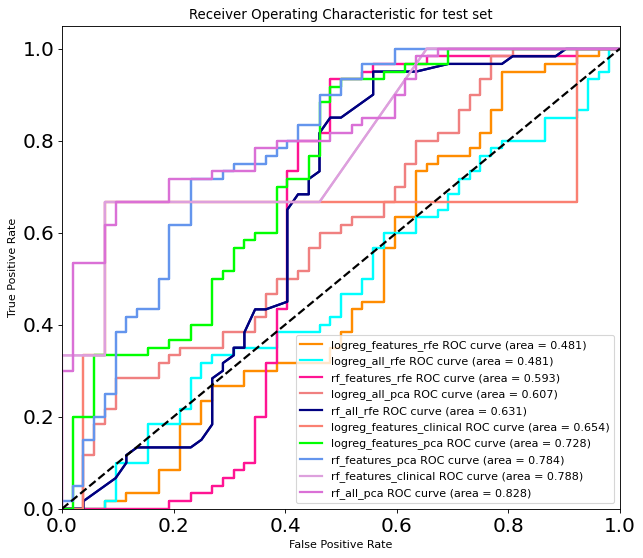

In [8]:
# fix a seed
seed = 0


# load data
import load_data
import glob

# study: 'texture', 'ph', 'CNN'
#study = 'texture' # <== CHANGE HERE
# modals
modal_list = ['FLAIR','T1', 'T1post','T2']

# study_list = ['TDA','texture','CNN','cmb']
# # study_list = ['texture']
# ICC_filt = 0

study_list = ['cmb']
ICC_filt = 2
for ICC_filt in [1]:
    if ICC_filt == 1:
        suffix = '_icc2'
    elif ICC_filt >= 3:
        suffix = '_icc%i' % ICC_filt
    else: 
        suffix = ''  

    for study in study_list:

        (origdir,basedir,imagedir,normdir,splitdir,out_dir,model_dir) = file_structure.file_dirs(study)
        corr_rfe_selected_list = np.load(os.path.join(out_dir,'rfe_%s_features_selected%s.npy' % 
                                                      (study.lower()[0:3],suffix)),allow_pickle=True).item()
        random_state_list = [2,4,6,8,10,12,14,16,18,20] 


        res_arr = []
        for fold in range(1):
            result = {}
            print('%s fold number: %d' % (study, fold))
            #(train_samples, train_pca , train_1p19q, train_age, train_KPS, train_gender, train_id, train_fnames)= load_data.load_data('train',fold)
            #(val_samples, val_pca , val_1p19q, val_age, val_KPS, val_gender, val_id, val_fnames)= load_data.load_data('val',fold)
            (test_samples, test_pca , test_1p19q, test_age,
             test_KPS, test_gender, test_id, feature_names)= load_data.load_data('test',fold, study,ICC_filt)

            fold_dir = os.path.join(splitdir,'fold_' + str(fold))

            # convert 1,0 into string: 'codel' and 'non-codel'
            test_1p19q_str = label_conversion(test_1p19q)

            # create the pandas dataframes
            data_test_imaging = pd.DataFrame(data=test_samples, columns=feature_names, index=test_1p19q_str)

            clinical_names = ['age', 'KPS', 'gender']
            test_clinical_df = pd.DataFrame(data = np.vstack((test_age, test_KPS, test_gender)).transpose(),
                                            columns = clinical_names, index=test_1p19q_str)
            test_clin_by_pt_df = test_clinical_df.assign(pid = pd.Series(test_id).values)
            test_clin_by_pt_df = test_clin_by_pt_df.groupby('pid').mean()
            #data_test_age = pd.DataFrame(data = np.hstack((test_age)), columns = ['age'], index=test_1p19q_str)


    #         for test_features, rfe_pca_flag in [(test_clin_by_pt_df,'clin_ppt')]:
            for test_features, rfe_pca_flag in [(test_clin_by_pt_df,'clin_ppt'),
                                                (test_clinical_df,'clinical'),
                                                (test_samples,'rfe'),
                                                (test_pca,'pca')]:
    #         for test_features, rfe_pca_flag in [(test_clinical_df,'clinical'),
    #                                             (test_samples,'rfe'),
    #                                             (test_pca,'pca')]:

                if rfe_pca_flag == 'rfe': # original features (i.e. non PCA features). This part needs to be filtered with corr_rfe selection
                    # create the pandas dataframes
                    test_features_df = pd.DataFrame(data=test_features, columns=feature_names, index=test_1p19q_str)

                    # Remove Flatness and LeastAxis since they are all 0s for every sample
                    drop_features = ['shape_Flatness_', 'shape_LeastAxis_']
                    drop_features = [elemt + modal for modal in modal_list for elemt in drop_features]

                    test_features_df = test_features_df.drop(drop_features, axis=1 , errors = 'ignore')

                    # obtain feature names to select from corr + RFE
                    corr_rfe_selected = corr_rfe_selected_list[fold]

                    # only the corr rfe selected features
                    test_features_df = test_features_df[corr_rfe_selected]

                elif rfe_pca_flag == 'pca': #PCA features
                    # create the pandas dataframes            
                    test_features_df = pd.DataFrame(data=test_features, index=test_1p19q_str)

                elif rfe_pca_flag == 'clinical': #PCA features
                    # create the pandas dataframes            
                    test_features_df = pd.DataFrame(data=test_features, index=test_1p19q_str)
                elif rfe_pca_flag == 'clin_ppt':  #clinical per patient variables
                    # create the pandas dataframes
                    test_1p19q_df = pd.DataFrame(data=np.vstack((test_1p19q, test_id)).T, 
                                                  columns=('1p19q','pid'), index=test_1p19q_str)
                    ct_1p19q = test_1p19q_df.groupby('pid')['1p19q'].mean().values

                    test_features_df = pd.DataFrame(data=test_features.values, columns=clinical_names, 
                                                    index=label_conversion(ct_1p19q))


                if rfe_pca_flag == 'clin_ppt': #clinical per patient variables
                    print('clin_ppt')
                else:
                    # features + clinical 
                    test_all_df = pd.concat([test_features_df, test_clinical_df], axis=1)


                for sample_case in ['features', 'all']: #features without clinical vs features + clinical
                    if ((rfe_pca_flag == 'clinical' or rfe_pca_flag == 'clin_ppt')  and sample_case != 'features'):
                        continue # only run clinical once through


                    for classifier in ['rf','logreg']:

                        model_name = classifier + '_' + sample_case + '_' + rfe_pca_flag + '_' + str(fold) +suffix + '.npy'
                        model_path = os.path.join(model_dir,model_name)
                        if not os.path.exists(model_path):
                            print(('Couldn''t find: ' + model_path))
                            continue
                        else:
                            params = np.load(model_path,allow_pickle=True).item() # load up model file if it exists

                        if classifier == 'rf': 
                            model = RandomForestClassifier() # copy over the parameters
                            for key,value in params.items():
                                setattr(model, key, value)
                        elif classifier == 'logreg':
                            model = LogisticRegression() # copy over the parameters
                            for key,value in params.items():
                                setattr(model, key, value)

                        # run the model to predict probabilities
                        if sample_case == 'features':
                            pred_probs = model.predict_proba(test_features_df)[:,1].reshape(-1,1)
                        elif sample_case == 'all':
                            pred_probs = model.predict_proba(test_all_df)[:,1].reshape(-1,1)

                        case_str = classifier + '_' + sample_case + '_' + rfe_pca_flag

                        if rfe_pca_flag == 'clin_ppt': #clinical per patient variables
                            organize_result(result, case_str, ct_1p19q, pred_probs, '_'+str(fold),suffix)
                        else:
                            organize_result(result, case_str, test_1p19q, pred_probs, '_'+str(fold),suffix)


            draw_ROC_curve(result,'_'+str(fold))
            res_arr = np.append(res_arr,result)
            df = pd.DataFrame.from_dict(result)
#             df.to_csv(os.path.join(out_dir,'%s_result_summary_fold_%d%s.csv' % (study,fold,suffix)))

        comb_res = {}
        for mtype in res_arr[0]:
            comb_res[mtype] = {}

        for i in range(len(res_arr)):
            for mtype in res_arr[i]:
                for stat in res_arr[i][mtype]:
                    if stat in comb_res[mtype]:
                        comb_res[mtype][stat] = np.append(comb_res[mtype][stat],res_arr[i][mtype][stat])
                    else: 
                        comb_res[mtype][stat] = [res_arr[i][mtype][stat]]


        mean_res = {}   
        for mtype in comb_res:
            mean_res[mtype] = {}
            for stat in comb_res[mtype]:
                mean_res[mtype][stat] = np.mean(comb_res[mtype][stat])

        df = pd.DataFrame.from_dict(mean_res)
#         df.to_csv(os.path.join(out_dir,'mean_%s_result_summary%s.csv' % (study,suffix)))

        std_res = {}   
        for mtype in comb_res:
            std_res[mtype] = {}
            for stat in comb_res[mtype]:
                std_res[mtype][stat] = np.std(comb_res[mtype][stat])

        df = pd.DataFrame.from_dict(std_res)
#         df.to_csv(os.path.join(out_dir,'std_%s_result_summary%s.csv' % (study,suffix)))


In [10]:
print(corr_rfe_selected)
print('rfe_%s_features_selected%s.npy' % (study.lower()[0:3],suffix))

['CNN_049_T1post', 'CNN_051_T1post', 'CNN_054_T1post', 'CNN_056_T1post', 'CNN_069_T1post', 'CNN_072_T1post', 'CNN_073_T1post', 'CNN_075_T1post', 'CNN_076_T1post', 'CNN_077_T1post', 'CNN_079_T1post', 'CNN_080_T1post', 'CNN_081_T1post', 'CNN_082_T1post', 'CNN_088_T1post', 'CNN_101_T1post', 'CNN_103_T1post', 'CNN_112_T1post', 'CNN_115_T1post', 'CNN_116_T1post', 'CNN_122_T1post', 'CNN_129_T1post', 'CNN_130_T1post', 'CNN_136_T1post', 'CNN_138_T1post', 'CNN_142_T1post', 'CNN_145_T1post', 'CNN_148_T1post', 'CNN_151_T1post', 'CNN_155_T1post', 'CNN_171_T1post', 'CNN_172_T1post', 'CNN_173_T1post', 'CNN_177_T1post', 'CNN_179_T1post', 'CNN_180_T1post', 'CNN_182_T1post', 'CNN_187_T1post', 'CNN_190_T1post', 'CNN_197_T1post', 'CNN_203_T1post', 'CNN_204_T1post', 'CNN_206_T1post', 'CNN_207_T1post', 'CNN_208_T1post', 'CNN_223_T1post', 'CNN_224_T1post', 'CNN_227_T1post', 'CNN_235_T1post', 'CNN_237_T1post', 'CNN_256_T1post', 'CNN_260_T1post', 'CNN_269_T1post', 'CNN_274_T1post', 'CNN_280_T1post', 'CNN_281_